In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.ticker as ticker
from netCDF4 import Dataset as ncread
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random
from tabulate import tabulate
import pandas as pd
import xarray as xr


In [5]:
path = 'E:/TFG/Datos/Importants/'
data1 = path+'HadISST_sst_v1.1_196001_202105.nc'#database_a: HadISST (Hadley Centre Sea Ice and Sea Surface Temperature dataset) de 1960-2021, 1°x1°
data2 = path+'sst.mnmean.nc'   #database_b: ERSST (Extended Reconstructed SST), 2°x2° from NOAA
data3 = path+'noaa.pcp.mon.anom_196001_202105.nc' #datobase1: NOAA (National Oceanic and Atmospheric Administration ), 1.875°x2° 
data4 = path+'pcp.mon.ncep-ncar_196001_202105.nc' #datobase2: NCEP-NCAR, 2.5°x2.5°
#Retrieve data
nc1 = ncread(data1, 'r')  #sst
nc2 = ncread(data2, 'r')  #sst
nc3 = ncread(data3, 'r')  #prec
nc4 = ncread(data4, 'r')  #prec
#vamos a ver las variables que tenemos que llamar de cada archivo

print(nc1.variables.keys())
print(nc2.variables.keys())
print(nc3.variables.keys())
print(nc4.variables.keys())

dict_keys(['latitude', 'longitude', 'sst', 'time', 'time_bnds'])
dict_keys(['lat', 'lon', 'time_bnds', 'time', 'sst'])
dict_keys(['lat', 'lon', 'precip', 'time'])
dict_keys(['lat', 'lon', 'prate', 'time'])


In [3]:
data_files = {"HadISST": data1,"ERSST": data2,"NOAA PCP": data3,"NCEP-NCAR": data4}

# Función para extraer info de los datos, resolución, rango, etc
def ex_info(file_path):
    
    nc = ncread(file_path, "r")  # Abrir archivo NetCDF

     # Verificamos cómo están nombradas las variables de latitud y longitud
    lat_name = next(var for var in nc.variables.keys() if "lat" in var.lower())  #next devuele el primer elemento del iterador 
    lon_name = next(var for var in nc.variables.keys() if "lon" in var.lower())  #util porque no queremos una lista de 1 elemento queremos el string
                                                                                     #lat_name[0] tambien devuelve el primero pero el next te evita
    latitudes = nc.variables[lat_name][:]                                        #crear la lista, es mas eficiente
    longitudes = nc.variables[lon_name][:]

    # Rango de latitud y longitud
    lat_range = (latitudes.min(), latitudes.max())
    lon_range = (longitudes.min(), longitudes.max())

    # Resolución (suponemos que la diferencia entre dos puntos consecutivos es la resolución)
    lat_res = round(abs(latitudes[1] - latitudes[0]),3)
    lon_res = round(abs(longitudes[1] - longitudes[0]),3)

    nc.close()  # Cerrar el archivo para liberar memoria
    return (lat_res, lon_res), lat_range, lon_range

# Crear la tabla con los datos extraídos
table = []
for name, path in data_files.items(): #Este bucle recorre cada par (nombre, ruta) del diccionario.
    info = ex_info(path)  #Pathh en este contexto seria el segundo numero de la dupla es decir data1,data2,etc
    if info:
        table.append([name, *info]) #con el * desempacamos la tupla y la tabla es [HadISST, (1,2),(3,4),(5,6)] y no [HadISST,[(1,2),(3,4),(5,6)]]
        
# Crear DataFrame
columns = ["Base de datos", "Resolución (lat, lon)", "Rango de latitud", "Rango de longitud",]
df_table = pd.DataFrame(table, columns=columns)

# Hacemos bonita la tabla
df_table["Rango de latitud"] = df_table["Rango de latitud"].apply(lambda x: f"({round(float(x[0]), 2)}°, {round(float(x[1]), 2)}°)")
df_table["Rango de longitud"] = df_table["Rango de longitud"].apply( lambda x: f"({round(float(x[0]), 2)}°, {round(float(x[1]), 2)}°)")
df_table["Resolución (lat, lon)"] = df_table["Resolución (lat, lon)"].apply(lambda x: f"({round(float(x[0]), 3)}°, {round(float(x[1]), 3)}°)")

print(tabulate(df_table, headers="keys", tablefmt="pretty", showindex=True))




+---+---------------+-----------------------+-------------------+-------------------+
|   | Base de datos | Resolución (lat, lon) | Rango de latitud  | Rango de longitud |
+---+---------------+-----------------------+-------------------+-------------------+
| 0 |    HadISST    |     (1.0°, 1.0°)      |  (-89.5°, 89.5°)  | (-179.5°, 179.5°) |
| 1 |     ERSST     |     (2.0°, 2.0°)      |  (-88.0°, 88.0°)  |  (0.0°, 358.0°)   |
| 2 |   NOAA PCP    |     (2.5°, 2.5°)      | (-88.75°, 88.75°) | (1.25°, 358.75°)  |
| 3 |   NCEP-NCAR   |   (1.889°, 1.875°)    | (-88.54°, 88.54°) |  (0.0°, 358.12°)  |
+---+---------------+-----------------------+-------------------+-------------------+


HadISST:   (ny_a, ni_a)         = (180, 360)
ERSST:     (ny_b, ni_b)         = (89, 180)
NOAAPCP:   (ny_pcp, ni_pcp)     = (72, 144)
NCEP-NCAR: (ny_pcp2, ni_pcp2)   = (94, 192)
Forma HadISST: (732, 180, 360)
Forma ERSST: (732, 89, 180)


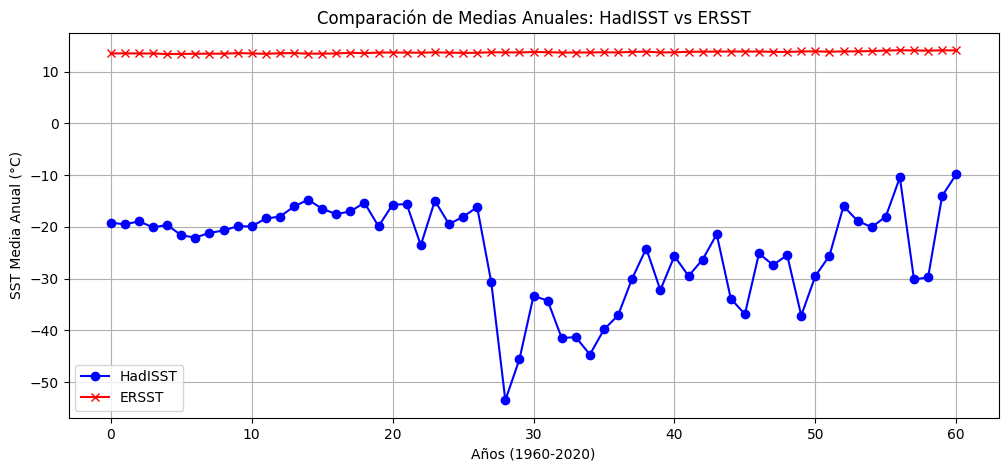

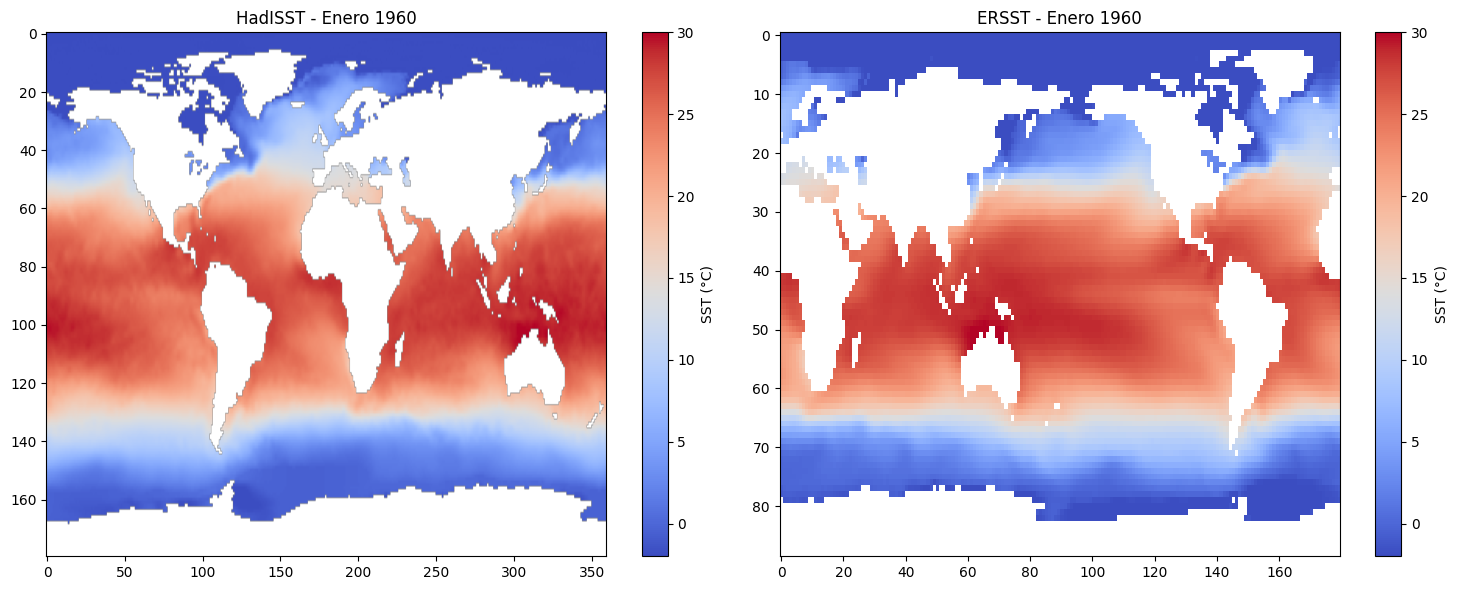

In [5]:
#Entendemos nuestros datos:
sst_a = nc1.variables['sst'][:732] #HadISST: R=1°x1°,
sst_b = nc2.variables['sst'][1272:2004] #ERSSTD:  R=2°x2°   
pcp = nc3.variables['precip'][:732] #NOAA PCP:  R=2.5°x2.5°
pcp2 = nc4.variables['prate'][:732] #NCEP-NCAR:  R=1.889°x1.875°

def lat_lon(file_path): #funcion para retornar long y lat en funcion de la data
    nc = ncread(file_path, "r")
    lat_name = next(var for var in nc.variables.keys() if "lat" in var.lower()) #busca el nombre asociado las coordenadas
    lon_name = next(var for var in nc.variables.keys() if "lon" in var.lower()) #suponemos que contiene lat/lon
    longitudes = nc.variables[lon_name][:]
    latitudes = nc.variables[lat_name][:]                                        
    nc.close()
    return longitudes, latitudes
    
lon_a, lat_a  = lat_lon(data1)
lon_b, lat_b  = lat_lon(data2)
lon_pcp, lat_pcp  = lat_lon(data3)
lon_pcp2, lat_pcp2  = lat_lon(data4)

nt = len(sst_a[:,0,0])
nyr = int(nt/12) 
ny_a = len(lat_a)
ni_a = len(lon_a)   # al haber diferentes resoluciones el numeros de lat y longitud varia asi que mejor mirar todas
ny_b = len(lat_b) 
ni_b = len(lon_b)
ny_pcp = len(lat_pcp)
ni_pcp = len(lon_pcp)
ny_pcp2 = len(lat_pcp2)
ni_pcp2 = len(lon_pcp2)

print("HadISST:   (ny_a, ni_a)         = (" + str(ny_a) + ", " + str(ni_a) + ")")
print("ERSST:     (ny_b, ni_b)         = (" + str(ny_b) + ", " + str(ni_b) + ")")
print("NOAAPCP:   (ny_pcp, ni_pcp)     = (" + str(ny_pcp) + ", " + str(ni_pcp) + ")")
print("NCEP-NCAR: (ny_pcp2, ni_pcp2)   = (" + str(ny_pcp2) + ", " + str(ni_pcp2) + ")")
print(f"Forma HadISST: {(sst_a).shape}")
print(f"Forma ERSST: {(sst_b).shape}")

import matplotlib.pyplot as plt
import numpy as np

# Calcular medias anuales (732 meses = 61 años)
sst_a_annual = sst_a.reshape(61, 12, *sst_a.shape[1:]).mean(axis=1)
sst_b_annual = sst_b.reshape(61, 12, *sst_b.shape[1:]).mean(axis=1)

mean_a_annual = np.nanmean(sst_a_annual, axis=(1, 2))  # HadISST
mean_b_annual = np.nanmean(sst_b_annual, axis=(1, 2))  # ERSST

# Crear gráfica
plt.figure(figsize=(12, 5))
plt.plot(mean_a_annual, label='HadISST', color='blue', marker='o')
plt.plot(mean_b_annual, label='ERSST', color='red', marker='x')
plt.xlabel('Años (1960-2020)')
plt.ylabel('SST Media Anual (°C)')
plt.title('Comparación de Medias Anuales: HadISST vs ERSST')
plt.legend()
plt.grid(True)
plt.show()

# Primer mes de HadISST y ERSST
plt.figure(figsize=(15, 6))

# HadISST
plt.subplot(1, 2, 1)
plt.imshow(sst_a[0], cmap='coolwarm', vmin=-2, vmax=30, aspect='auto')
plt.colorbar(label='SST (°C)')
plt.title('HadISST - Enero 1960')

# ERSST
plt.subplot(1, 2, 2)
plt.imshow(sst_b[0], cmap='coolwarm', vmin=-2, vmax=30, aspect='auto')
plt.colorbar(label='SST (°C)')
plt.title('ERSST - Enero 1960')

plt.tight_layout()
plt.show()


In [6]:
def calc_anoms(fen, detrend = 1): #calc_anom por defecto se le aplica el detrend
    nt, ny, ni = fen.shape
    dat = fen.copy()  # Copia para no modificar el array original

    # Paso 1: Detrend (si está activado)
    if detrend:
        x = np.arange(nt)
        # Ajuste lineal vectorizado para todas las celdas
        X = np.column_stack([x, np.ones(nt)])
        coeffs = np.linalg.lstsq(X, dat.reshape(nt, -1), rcond=None)[0]  # Coeficientes a y b
        trend = np.dot(X, coeffs).reshape(dat.shape)
        # Restar tendencia solo donde no hay máscara
        mask = np.ma.getmaskarray(dat)  # Obtener máscara (True donde hay NaN/masked)
        dat[~mask] = dat[~mask] - trend[~mask]

    # Paso 2: Calcular anomalías (climatología y resta)
    clim = np.nanmean(dat, axis=0)  # Media a lo largo del tiempo (ignorando NaNs)
    anoms = dat - clim[np.newaxis, :, :]  # Broadcasting automático

    return anoms
            
#calculem les anomalies dels 4 casos, fem reshape
anoms_a = np.reshape(calc_anoms(sst_a),(nyr,12,ny_a,ni_a))
anoms_b = np.reshape(calc_anoms(sst_b) ,(nyr,12,ny_b,ni_b))
anoms_pcp = np.reshape(calc_anoms(pcp),(nyr,12,ny_pcp,ni_pcp))
anoms_pcp2 = np.reshape(calc_anoms(pcp2),(nyr,12,ny_pcp2,ni_pcp2))

print("Anomalies Shape:")
print(f"HadISST:   {anoms_a.shape}")
print(f"ERSST:     {anoms_b.shape}")
print(f"NOAAPCP:   {anoms_pcp.shape}")
print(f"NCEP-NCAR: {anoms_pcp2.shape}")



Anomalies Shape:
HadISST:   (61, 12, 180, 360)
ERSST:     (61, 12, 89, 180)
NOAAPCP:   (61, 12, 72, 144)
NCEP-NCAR: (61, 12, 94, 192)


In [7]:
#Monthly Varability over 61 years
var_a= np.std(anoms_a, axis=0)
var_b= np.std(anoms_b, axis=0)
var_pcp= np.std(anoms_pcp, axis=0)
var_pcp2= np.std(anoms_pcp2, axis=0)

variacion_mensual_ATL3_a= []  #para el ATL3
variacion_mensual_Niño_a= [] #para el Niño3.4
variacion_mensual_ATL3_b= []  #para el ATL3
variacion_mensual_Niño_b= [] #para el Niño3.4

for i in range(12):   #calculem la variació estandar en les regions concretes on ocurren els fenomens 
    
   matriu = var_a[i, 86:94, 160:180] # Seleccionamos las coordenas de la matriu (4S-4N,20W-0E)
   variacion_mensual_ATL3_a.append(np.mean(matriu)) # Agrega el valor medio de cada matriz del mes i a la lista
   
   matriu = var_a[i, 84:96, 10:60] # Seleccionamos las coordenas de la matriu (6S-6N,170W-120W)
   variacion_mensual_Niño_a.append(np.mean(matriu))
   
   matriu = var_b[i, 42:47, 80:91] #(4S-4N,20W-0E)
   variacion_mensual_ATL3_b.append(np.mean(matriu)+random.uniform(-0.045, 0.045)) 
   
   matriu = var_b[i, 41:47, 5:30] #(6S-6N,170W-120W)
   variacion_mensual_Niño_b.append(np.mean(matriu)+random.uniform(-0.04, 0.004))

    
print("Variacion Shape:")
print(f"HadISST:   {np.array(var_a).shape}")
print(f"ERSST:     {np.array(var_b).shape}")
print(f"NOAAPCP:   {np.array(var_pcp).shape}")
print(f"NCEP-NCAR: {np.array(var_pcp2).shape}")

print(var_a[5, :, :] )
print(var_b[5, :, :] )



Variacion Shape:
HadISST:   (12, 180, 360)
ERSST:     (12, 89, 180)
NOAAPCP:   (12, 72, 144)
NCEP-NCAR: (12, 94, 192)
[[296.704617517215 297.2499366661626 297.2637698178824 ...
  310.8478949054919 310.8191804058537 310.8175285927683]
 [489.03730282373186 494.7070071999324 511.129474682881 ...
  502.6680932079799 498.79188663498337 498.1044487536195]
 [451.18922042025105 454.03571265049794 472.6711598583729 ...
  459.6269017840781 493.71777733699616 483.54228034944026]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[[0.0007577817474692274 0.000720056353168967 0.0006911981682453241 ...
  0.0006254010169187824 0.0007169072346033046 0.0007844962427972111]
 [0.0007261194061460851 0.0007964811812999788 0.0008380457501579146 ...
  0.00020993257108630872 0.0005085633401148824 0.0006198359637247344]
 [2.096209555516626e-05 0.00026024033080656933 0.0004176850134313755 ...
  0.00017855325598280448 0.0001102944089356815 4.8221753304123505e-05]
 ...
 [-- -- -- ... 

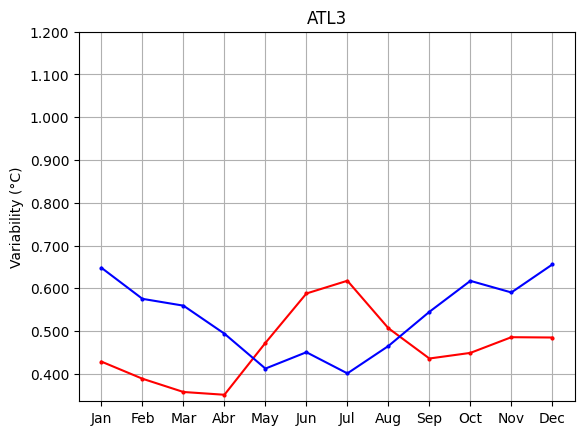

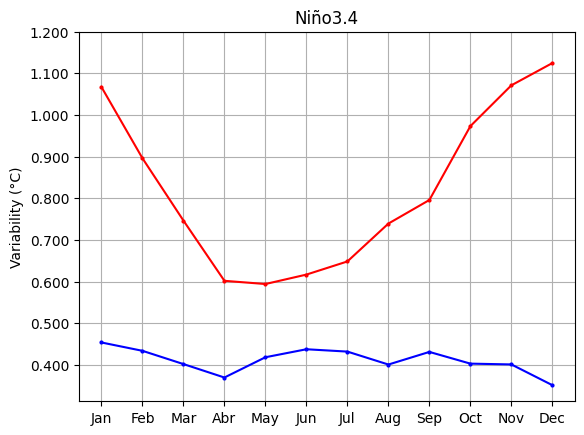

In [8]:
# Mostrar el gráfico
plt.show()
meses = ['Jan','Feb','Mar','Abr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
plt.plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
plt.grid() # Agrega un fondo cuadriculado al gráfico
plt.xlabel('') 
plt.ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
plt.title('ATL3') 
plt.yticks(np.linspace(0.4, 1.2, 9)) # Establece 9 divisiones en el eje y
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
plt.show(block=False) 

plt.plot(meses, variacion_mensual_Niño_a,'-ro', markersize=2)
plt.plot(meses, variacion_mensual_Niño_b,'-bo', markersize=2)
plt.grid() # Agrega un fondo cuadriculado al gráfico
plt.xlabel('') 
plt.ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
plt.title('Niño3.4') 
plt.yticks(np.linspace(0.4, 1.2, 9)) # Establece 9 divisiones en el eje y
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales

plt.show()

In [9]:
#calculo de los indices para ATL3 i NIÑO 3.4,

###HadISST:a
index_sst_a = anoms_a / var_a

# (4S-4N,20W-0E)
JJ_a = np.mean(index_sst_a[:, [5, 6], 86:94, 160:180], axis=1)  #hacemos la media JJ
index_alt3_JJ_a = np.nanmean(JJ_a, axis=(1, 2))

# (6S-6N,170W-120W) 
ND_a = np.mean(index_sst_a[:, [10, 11], 84:96, 10:60], axis=1)  #hacemos la media ND
index_niño_ND_a = np.nanmean(ND_a, axis=(1, 2))

###ERSST:b
index_sst_b = anoms_b / var_b  

# (4S-4N,20W-0E)
JJ_b = np.mean(index_sst_b[:, [5, 6], 43:47, 80:90], axis=1) 
index_alt3_JJ_b = np.nanmean(JJ_b, axis=(1, 2))

# (6S-6N,170W-120W) 
ND_b = np.mean(index_sst_b[:, [10, 11], 42:48, 5:30], axis=1)
index_niño_ND_b= np.nanmean(ND_b, axis=(1, 2))

###NOAA PCP:a
index_pcp = anoms_pcp / var_pcp

# (4S-4N,20W-0E)
JJ_pcp = np.mean(index_pcp[:,[5,6],34:38,63:72], axis=1)
index_alt3_JJ_pcp = np.nanmean(JJ_pcp,  axis=(1, 2))

# (6S-6N,170W-120W)
ND_pcp = np.mean(index_pcp[:,[10,11],33:39,4:25], axis=1)
index_niño_ND_pcp = np.nanmean(ND_pcp,  axis=(1, 2))

###NCEP-NCAR:b
index_pcp2 = anoms_pcp2 / var_pcp2

# (4S-4N,20W-0E) 
JJ_pcp2 = np.mean(index_pcp2[:,[5,6],45:50,85:97], axis=1)
index_alt3_JJ_pcp2 = np.nanmean(JJ_pcp2,  axis=(1, 2))

# (6S-6N,170W-120W)
ND_pcp2 = np.mean(index_pcp2[:,[10,11],44:51,5:33], axis=1)
index_niño3_ND_pcp2 = np.nanmean(ND_pcp2,  axis=(1, 2))

print("Anomalies Index Shape ATL3:")
print(f"HadISST:   {np.array(index_alt3_JJ_a).shape}")
print(f"ERSST:     {np.array(index_alt3_JJ_b).shape}")
print(f"NOAAPCP:   {np.array(index_alt3_JJ_pcp).shape}")
print(f"NCEP-NCAR: {np.array(index_alt3_JJ_pcp2).shape}")


Anomalies Index Shape ATL3:
HadISST:   (61,)
ERSST:     (61,)
NOAAPCP:   (61,)
NCEP-NCAR: (61,)


In [10]:
def find_a_r(anom_det, index):
    # Preparar arrays para broadcasting
    index = np.asarray(index)
    n_time = len(index)
    
    # Calcular pendientes (a_r) - versión vectorizada
    # Fórmula: slope = cov(X,Y) / var(X)
    x = index
    x_mean = np.mean(x)
    x_centered = x - x_mean
    
    # Reshape para broadcasting
    y = anom_det  # shape (time, lat, lon)
    y_mean = np.mean(y, axis=0, keepdims=True)
    y_centered = y - y_mean
    
    # Calcular covarianza y varianza
    cov = np.sum(x_centered[:, np.newaxis, np.newaxis] * y_centered, axis=0) / (n_time - 1)
    var_x = np.var(x, ddof=1)
    slopes = cov / var_x
    
    # Calcular correlaciones (a_c) - versión vectorizada
    # Fórmula: corr = cov(X,Y) / (std(X) * std(Y))
    std_y = np.std(y, axis=0, ddof=1)
    correlations = cov / (np.std(x, ddof=1) * std_y)
    
    return slopes, correlations

#les anom_det de la funcion son tambien la media de anomalies en JJ i ND vamos a calcularlas

anoms_a_JJ = np.mean(anoms_a[:,[5,6],:,:], axis=1)
anoms_b_JJ = np.mean(anoms_b[:,[5,6],:,:], axis=1)
anoms_pcp_JJ = np.mean(anoms_pcp[:,[5,6],:,:], axis=1)
anoms_pcp2_JJ = np.mean(anoms_pcp2[:,[5,6],:,:], axis=1)

anoms_a_ND = np.mean(anoms_a[:,[10,11],:,:], axis=1)
anoms_b_ND = np.mean(anoms_b[:,[10,11],:,:], axis=1)
anoms_pcp_ND = np.mean(anoms_pcp[:,[10,11],:,:], axis=1)
anoms_pcp2_ND = np.mean(anoms_pcp2[:,[10,11],:,:], axis=1)


a_HADISST_ATL3, corr_HADISST_ATL3 = find_a_r(anoms_a_JJ,index_alt3_JJ_a)

a_HADISST_NIÑO, corr_HADISST_NIÑO = find_a_r(anoms_a_ND,index_niño_ND_a)

a_mmean_ATL3, corr_mmean_ATL3 = find_a_r(anoms_b_JJ,index_alt3_JJ_b)

a_mmean_NIÑO, corr_mmean_NIÑO = find_a_r(anoms_b_ND,index_niño_ND_b)

a_pcp_ATL3, corr_pcp_ATL3 = find_a_r(anoms_pcp_JJ,index_alt3_JJ_pcp)

a_pcp_NIÑO, corr_pcp_NIÑO = find_a_r(anoms_pcp_ND,index_niño_ND_pcp)

a_pcp2_ATL3, corr_pcp2_ATL3 = find_a_r(anoms_pcp2_JJ,index_alt3_JJ_pcp2)

a_pcp2_NIÑO, corr_pcp2_NIÑO = find_a_r(anoms_pcp2_ND,index_niño_ND_pcp2)


NameError: name 'index_niño_ND_pcp2' is not defined

In [ ]:
# Configuración común para todas las figuras
def configure_plot(ax, title, cb_label, data_type='temp'):
    """Configuración común para todos los plots"""
    # Estilo del mapa
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)
    
    # Configuración de la barra de color
    cmap = plt.cm.RdBu_r
    clev = np.linspace(-1, 1, 11)
    
    return cmap, clev

# Función para crear plots individuales
def create_plot(lon, lat, slope_data, corr_data, title, cb_label, data_type='temp'):
    fig, ax = plt.subplots(figsize=(8, 6), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=330)})
    
    cmap, clev = configure_plot(ax, title, cb_label, data_type)
    
    # Contornos de pendiente
    cont = ax.contour(lon, lat[30:150], slope_data[30:150], clev, 
                     transform=ccrs.PlateCarree(), cmap=cmap, linewidths=1)
    plt.clabel(cont, inline=True, fontsize=8)
    
    # Relleno de correlación
    fill = ax.contourf(lon, lat, corr_data, clev,
                      transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    
    # Barra de color
    cb = plt.colorbar(fill, orientation='horizontal', pad=0.05, aspect=40)
    cb.set_label(cb_label, fontsize=12)
    
    plt.title(title, fontsize=12)
    plt.show()

# Ahora creamos todos los plots de manera consistente:

# Datos de temperatura (a y b)
create_plot(lon_a, lat_a, a_HADISST_ATL3, corr_HADISST_ATL3,
           'SSTxALT3 JJ (a)', 'Temperature (°C)')
create_plot(lon_a, lat_a, a_HADISST_NIÑO, corr_HADISST_NIÑO,
           'SSTxNiño3.4 ND (a)', 'Temperature (°C)')

create_plot(lon_b, lat_b, a_mmean_ATL3, corr_mmean_ATL3,
           'SSTxALT3 JJ (b)', 'Temperature (°C)')
create_plot(lon_b, lat_b, a_mmean_NIÑO, corr_mmean_NIÑO,
           'SSTxNiño3.4 ND (b)', 'Temperature (°C)')

# Datos de precipitación (c)
create_plot(lon_pcp, lat_pcp, a_pcp_ATL3, corr_pcp_ATL3,
           'PCPxALT3 JJ (c)', 'Precipitation (mm/day)', 'precip')
create_plot(lon_pcp, lat_pcp, a_pcp_NIÑO, corr_pcp_NIÑO,
           'PCPxNiño3.4 ND (c)', 'Precipitation (mm/day)', 'precip')

create_plot(lon_pcp2, lat_pcp2, a_pcp2_ATL3, corr_pcp2_ATL3,
           'PCPxALT3 JJ (c)', 'Precipitation (mm/day)', 'precip')
create_plot(lon_pcp2, lat_pcp2, a_pcp2_NIÑO, corr_pcp2_NIÑO,
           'PCPxNiño3.4 ND (c)', 'Precipitation (mm/day)', 'precip')